<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/CUDA_Accelerated_H_Tree_Fractals_GDSTK_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [5]:
# %% Install libraries (Colab)
!pip install --quiet --upgrade "gdstk>=0.9.53"
!pip install --quiet "cupy-cuda11x"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 MB 26.3 MB/s eta 0:00:00


In [6]:
# %% Imports

# Core numerical libraries
import numpy as np          # CPU arrays and math
import cupy as cp           # GPU arrays and math (CUDA + Python)

# Plotting (preview on CPU)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 1200

# Layout/ mask geometry
import gdstk                # GDSII/ OASIS geometry library

In [7]:
USE_GPU = True


def generate_bar_centers(order, base_length):
    """Example: generate N centers for bars; CPU or GPU."""
    if USE_GPU:
        xs_gpu = cp.linspace(-base_length / 2.0, base_length / 2.0, 4 ** order)
        ys_gpu = cp.zeros_like(xs_gpu)

        # Bring back to CPU as NumPy arrays for gdstk and Matplotlib
        xs = cp.asnumpy(xs_gpu)
        ys = cp.asnumpy(ys_gpu)
    else:
        xs = np.linspace(-base_length / 2.0, base_length / 2.0, 4 ** order)
        ys = np.zeros_like(xs)

    return xs, ys


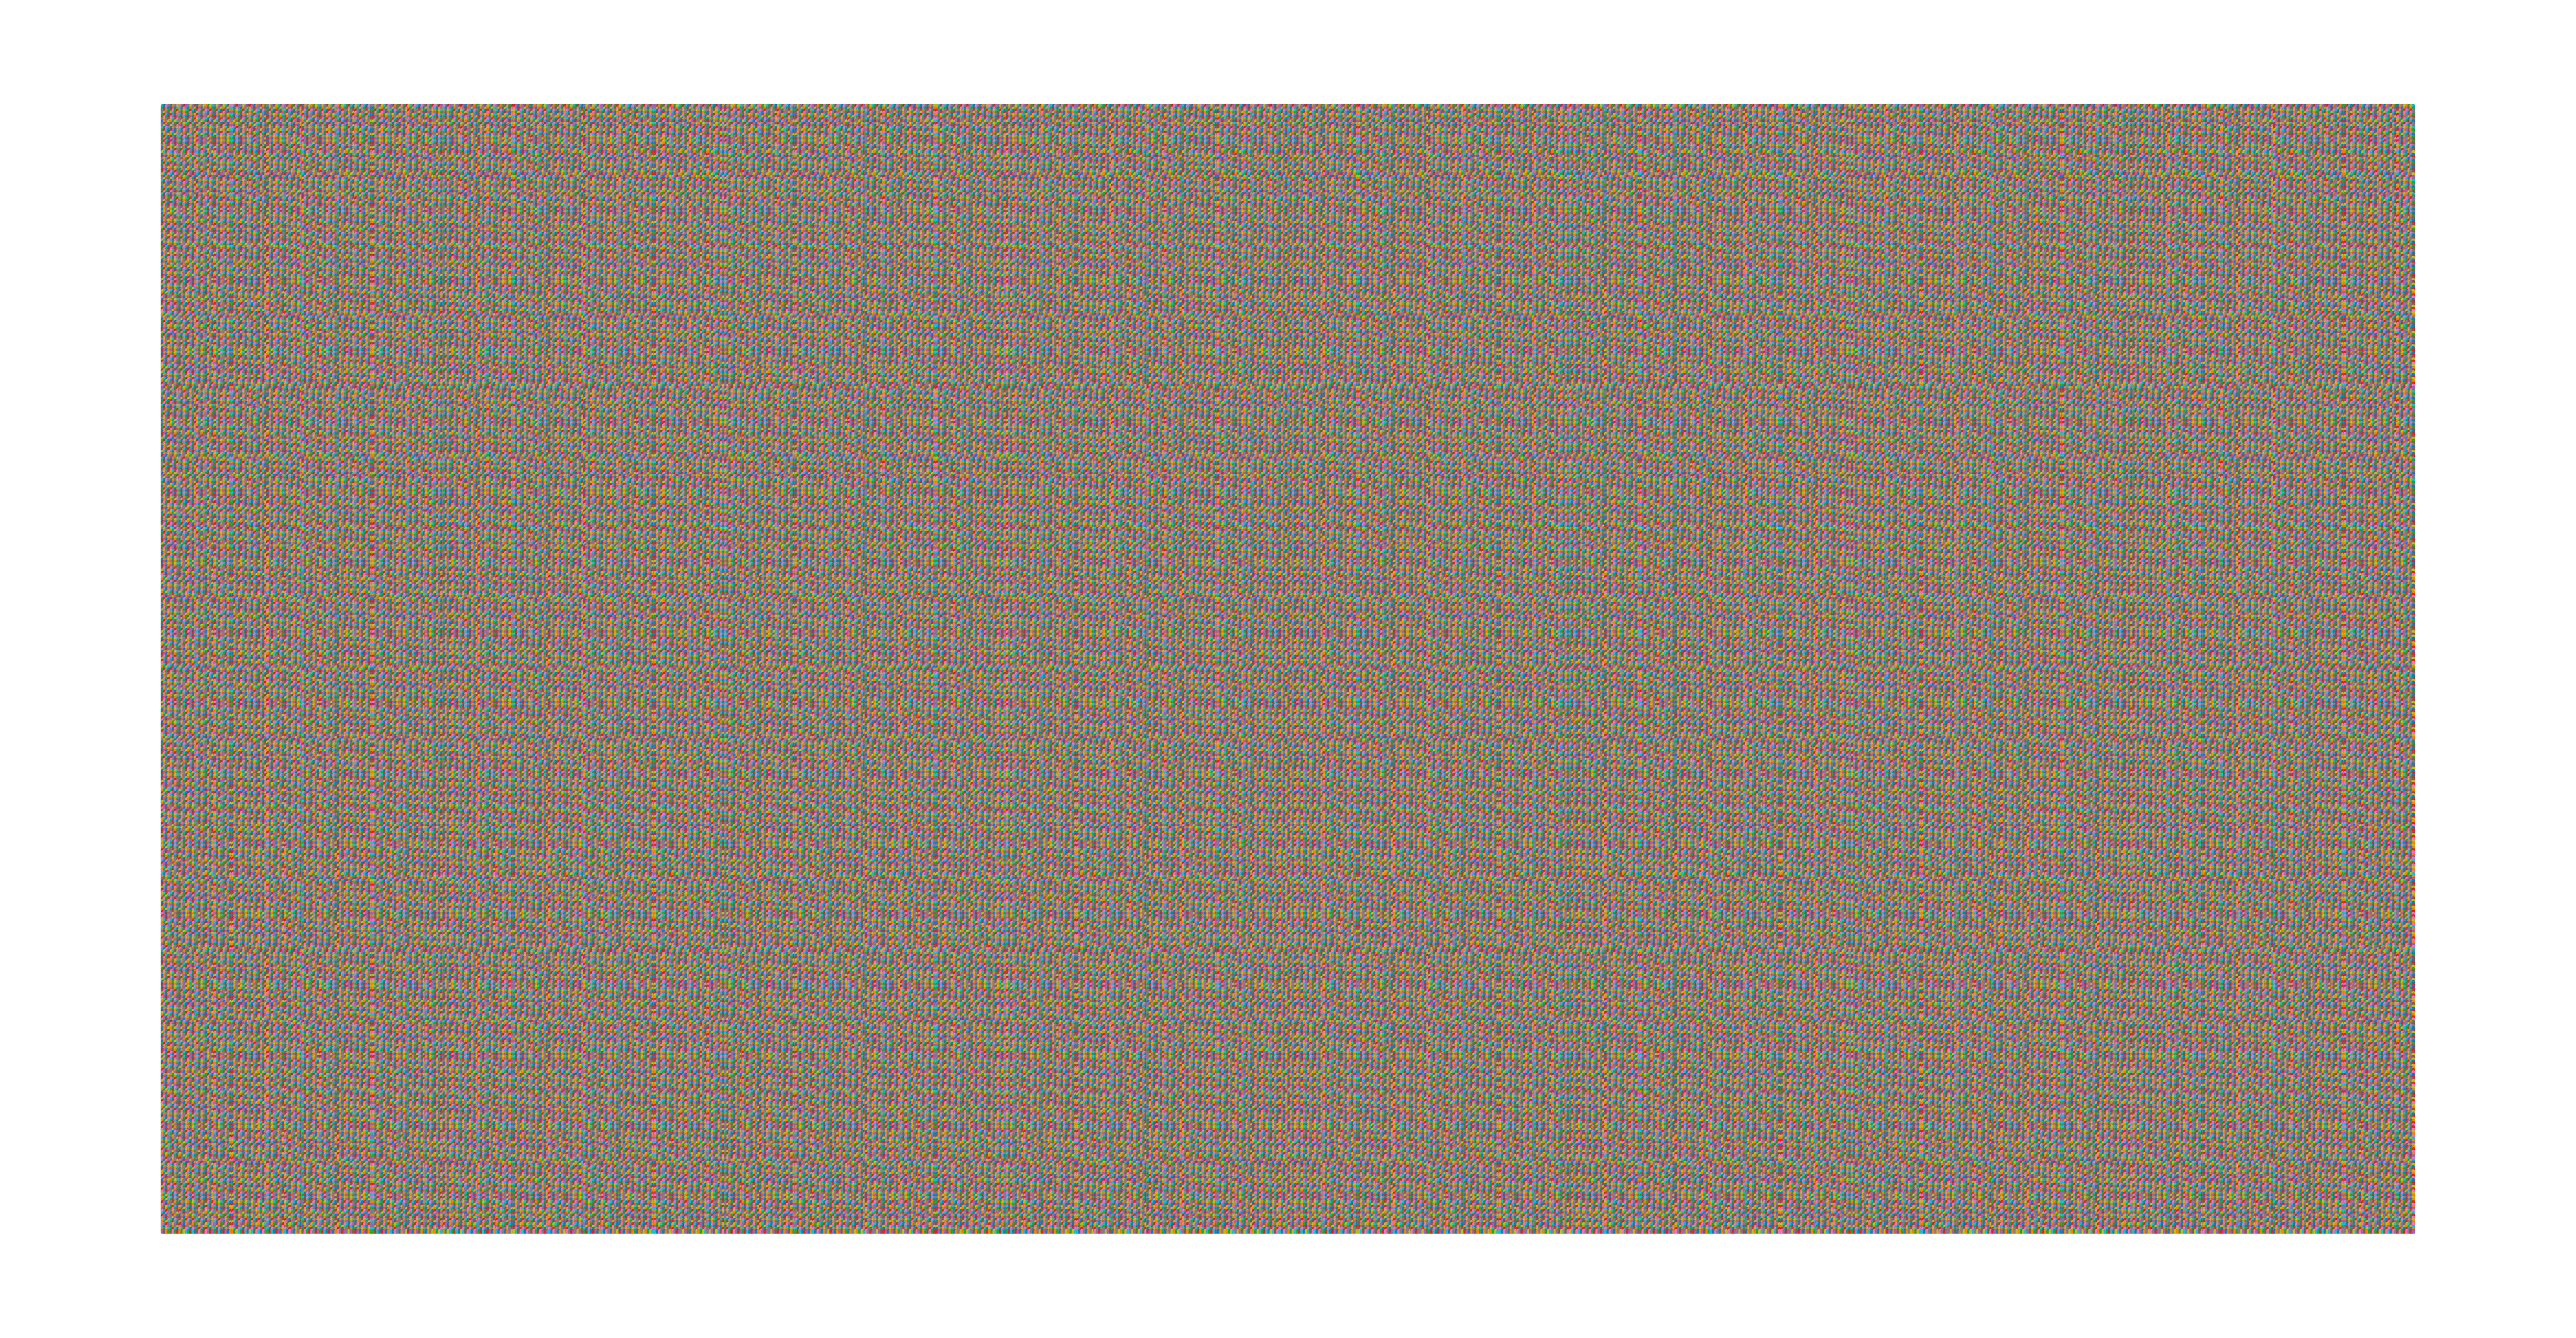

In [8]:
# %% Control knobs
ORDER = 10              # fractal depth
W_MIN = 0.003           # µm, thinnest branch (3 nm)
LEN_ROOT = 100.0       # µm, span of top-level H
LAYER = 1              # mask layer
EXPORT_GDS = True
EXPORT_OASIS = True
PREVIEW = True

ROOT_WID = W_MIN * (2 ** (ORDER - 1))  # widest trunk

# %% Build library + cell
lib = gdstk.Library()
cell = lib.new_cell(f"HTREE{ORDER}")


def htree(cell_obj, x, y, length, width, order):
    """Recursive canopy H-tree centered at (x, y)."""
    if order == 0:
        return

    # Horizontal bar
    cell_obj.add(
        gdstk.rectangle(
            (x - length / 2, y - width / 2),
            (x + length / 2, y + width / 2),
            layer=LAYER,
        )
    )

    # Vertical stems at ends
    stem_len = length / 2.0
    half_w = width / 2.0

    for sign in (-1.0, 1.0):
        stem_x = x + sign * (length / 2.0)

        cell_obj.add(
            gdstk.rectangle(
                (stem_x - half_w, y - stem_len / 2.0),
                (stem_x + half_w, y + stem_len / 2.0),
                layer=LAYER,
            )
        )

        # Recurse at upper + lower tips
        htree(cell_obj, stem_x, y + stem_len / 2.0, length / 2.0, width / 2.0, order - 1)
        htree(cell_obj, stem_x, y - stem_len / 2.0, length / 2.0, width / 2.0, order - 1)


# Build fractal
htree(cell, 0.0, 0.0, LEN_ROOT, ROOT_WID, ORDER)

# %% CPU preview with Matplotlib
if PREVIEW:
    fig, ax = plt.subplots()
    for poly in cell.polygons:
        pts = np.asarray(poly.points)
        pts = np.vstack([pts, pts[0]])  # close polygon
        ax.plot(pts[:, 0], pts[:, 1], linewidth=0.5)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.show()

# %% Export
if EXPORT_GDS:
    lib.write_gds(f"htree_order{ORDER}.gds")

if EXPORT_OASIS:
    # compression_level=6 is the default; you can tune it 0–9
    lib.write_oas(f"htree_order{ORDER}.oas")